In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 84.8MB/s]


In [4]:
!unzip /content/emotions-dataset-for-nlp.zip

Archive:  /content/emotions-dataset-for-nlp.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

In [9]:
dfTrain = pd.read_csv('train.txt', delimiter = ';', names = ['text', 'label'])
dfVal = pd.read_csv('val.txt', delimiter = ';', names = ['text', 'label'])

In [10]:
len(dfTrain)

16000

In [11]:
dfTrain.label.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [14]:
dfTest = pd.read_csv('test.txt', delimiter = ';', names = ['text', 'label'])

In [15]:
dfTest.shape

(2000, 2)

In [20]:
dfTrain['enco'] = le.fit_transform(dfTrain['label'])
dfVal['enco'] = le.transform(dfVal['label'])
dfTest['enco'] = le.transform(dfTest['label'])

In [21]:
dfTrain

,text,label,enco
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,4
15996,i am now turning and i feel pathetic that i am...,sadness,4
15997,i feel strong and good overall,joy,2
15998,i feel like this was such a rude comment and i...,anger,0


In [23]:
dfTrain['label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [27]:
dfTest['label'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = stopwords.words('english')

In [29]:
def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [30]:
def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)

    return text

In [32]:
dfTrain["clean_text"] = dfTrain["text"].apply(clean_text)
dfTest["clean_text"] = dfTest["text"].apply(clean_text)
dfVal["clean_text"] = dfVal["text"].apply(clean_text)

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [34]:
dfTrain["enco"] = le.fit_transform(dfTrain["label"])
dfVal["enco"] = le.transform(dfVal["label"])
dfTest["enco"] = le.transform(dfTest["label"])

In [35]:
dfTrain[['label', 'enco']].drop_duplicates(keep='first')

,label,enco
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [36]:
xTrain, xTest, yTrain, yTest = dfTrain.clean_text, dfVal.clean_text, dfTrain.enco, dfVal.enco

In [40]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

epochs = 30
act = "swish"
optim = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xTrain)

In [42]:
trainX = tokenizer.texts_to_sequences(xTrain)
testX = tokenizer.texts_to_sequences(xTest)
test = tokenizer.texts_to_sequences(dfTest.clean_text)

vocabSize = len(tokenizer.word_index) + 1

In [44]:
import numpy as np

In [46]:
lenTrain = [len(i) for i in trainX]
lenTest = [len(i) for i in testX]
length = lenTrain + lenTest

maxlen = np.max(length)
maxlen

35

In [47]:
trainX = pad_sequences(trainX, padding = 'post', maxlen = maxlen)
testX = pad_sequences(testX, padding = 'post', maxlen = maxlen)
test = pad_sequences(test, padding = 'post', maxlen = maxlen)

In [48]:
dummyTestY = np_utils.to_categorical(yTest)
dummyTrainY = np_utils.to_categorical(yTrain)

In [51]:
!kaggle datasets download -d takuok/glove840b300dtxt

100% 2.08G/2.08G [00:26<00:00, 98.2MB/s]
100% 2.08G/2.08G [00:26<00:00, 85.4MB/s]


In [52]:
!unzip '/content/glove840b300dtxt.zip'

Archive:  /content/glove840b300dtxt.zip
  inflating: glove.840B.300d.txt     


In [53]:
import tqdm

In [56]:
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('/content/glove.840B.300d.txt','r') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [57]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 2196018it [03:22, 10870.47it/s]


In [58]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocabSize, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=optim, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           4519500   
                                                                 
 dropout (Dropout)           (None, 35, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 33, 32)            28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 11, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 32)             3104      
                                                        

In [59]:
checkpoint_filepath = 'content/Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [69]:
history = model.fit(trainX, dummyTrainY, epochs=17, verbose=1, validation_data=(testX, dummyTestY), batch_size=128, callbacks=[model_checkpoint_callback])
loss, accuracy = model.evaluate(trainX, dummyTrainY, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(testX, dummyTestY, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/17
125/125 [==============================] - 25s 199ms/step - loss: 0.1100 - accuracy: 0.9616 - val_loss: 0.2194 - val_accuracy: 0.9245
Epoch 2/17
125/125 [==============================] - 26s 204ms/step - loss: 0.1030 - accuracy: 0.9653 - val_loss: 0.2239 - val_accuracy: 0.9265
Epoch 3/17
125/125 [==============================] - 25s 201ms/step - loss: 0.0974 - accuracy: 0.9661 - val_loss: 0.2444 - val_accuracy: 0.9205
Epoch 4/17
125/125 [==============================] - 25s 198ms/step - loss: 0.0879 - accuracy: 0.9697 - val_loss: 0.2383 - val_accuracy: 0.9205
Epoch 5/17
125/125 [==============================] - 25s 202ms/step - loss: 0.0919 - accuracy: 0.9690 - val_loss: 0.2406 - val_accuracy: 0.9210
Epoch 6/17
125/125 [==============================] - 25s 201ms/step - loss: 0.0850 - accuracy: 0.9708 - val_loss: 0.2455 - val_accuracy: 0.9210
Epoch 7/17
125/125 [==============================] - 25s 203ms/step - loss: 0.0784 - accuracy: 0.9726 - val_loss: 0.2487 - val_ac

In [70]:
model.save('content/emotionAnalysis.h5')

In [73]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.9265000224113464


In [74]:
model.load_weights(checkpoint_filepath)

In [76]:
predict = model.predict(test)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

63/63 [==============================] - 3s 27ms/step


array([4, 4, 4, ..., 2, 2, 5])

In [77]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(dfTest["enco"], predict_class)
conf

array([[261,   2,   3,   0,   8,   1],
       [ 13, 194,   0,   0,   7,  10],
       [  4,   1, 647,  36,   0,   7],
       [  2,   0,  19, 137,   1,   0],
       [ 16,   6,   6,   2, 550,   1],
       [  2,  11,   5,   0,   3,  45]])

<Axes: >

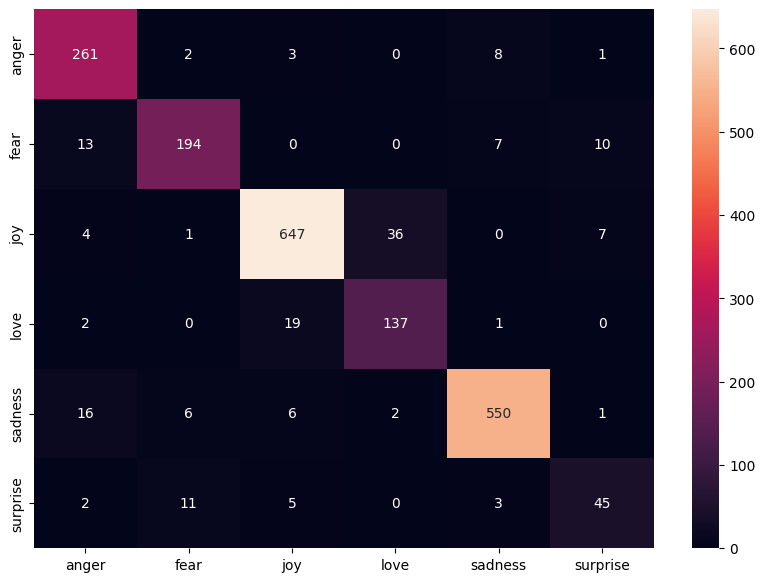

In [79]:
df_cm = pd.DataFrame(conf, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [82]:
from sklearn.metrics import classification_report

print(classification_report(dfTest["enco"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.88      0.95      0.91       275
        fear       0.91      0.87      0.89       224
         joy       0.95      0.93      0.94       695
        love       0.78      0.86      0.82       159
     sadness       0.97      0.95      0.96       581
    surprise       0.70      0.68      0.69        66

    accuracy                           0.92      2000
   macro avg       0.86      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000

